<a href="https://colab.research.google.com/github/Justworkname/Tamil_lab_Chance_Gammill/blob/main/CFar_ViT_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vit CFar

## Import

In [7]:
!pip install -q torchinfo

In [143]:
import torch
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torchvision.datasets.folder import has_file_allowed_extension
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Hyper parameters

In [157]:
num_epochs=50
batch_size=5
img_size=32
in_channels=3 #RGB
patch_size=4
embedding_dim=patch_size**2*3 ## just realized i did not account for teh RGB values on the other one and I am going to be annoyed with my self if that was the issue
head=12
dropout=0.1
hidden_size=192
layers = 8
num_classes=10 # will be over written in data phase

## Data

Transform

In [158]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

Load

In [159]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
num_classes=len(class_names)
train_loader, test_loader,class_names

Files already downloaded and verified
Files already downloaded and verified


(<torch.utils.data.dataloader.DataLoader at 0x7da1e0318f70>,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

Visualize Image

In [160]:
image_batch, label_batch = next(iter(train_loader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 32, 32]), tensor(6))

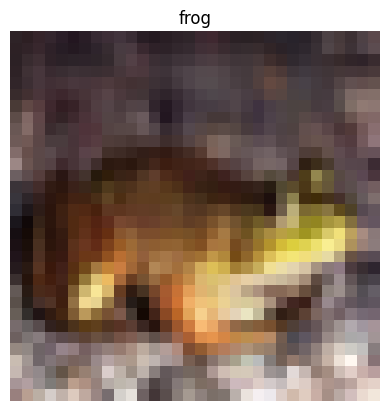

In [161]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## Patch embeding layer

In [125]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels=in_channels,
                 patch_size=patch_size,
                 embedding_dim=embedding_dim):
        super().__init__()

        self.patch_size = patch_size

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,  # Corrected typo from kernels_size to kernel_size
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self,x):
        image_resolution = x.shape[-1]

        x_patched =self.patcher(x)
        x_flattened= self.flatten(x_patched)

        return x_flattened.permute(0,2,1)

## Transformer Encoder Layer

In [91]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                       nhead=head,
                                                       dim_feedforward=hidden_size,
                                                       dropout=dropout,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)
transformer_encoder_layer


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
  )
  (linear1): Linear(in_features=48, out_features=192, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=192, out_features=48, bias=True)
  (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

Display Model

In [92]:
summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [5, 64, 48]               28,272
Total params: 28,272
Trainable params: 28,272
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.06
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.06

## Stack Transformer Encoder

In [89]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=layers)


In [122]:
summary(model=transformer_encoder)

Layer (type:depth-idx)                                       Param #
TransformerEncoder                                           --
├─ModuleList: 1-1                                            --
│    └─TransformerEncoderLayer: 2-1                          --
│    │    └─MultiheadAttention: 3-1                          9,408
│    │    └─Linear: 3-2                                      9,408
│    │    └─Dropout: 3-3                                     --
│    │    └─Linear: 3-4                                      9,264
│    │    └─LayerNorm: 3-5                                   96
│    │    └─LayerNorm: 3-6                                   96
│    │    └─Dropout: 3-7                                     --
│    │    └─Dropout: 3-8                                     --
│    └─TransformerEncoderLayer: 2-2                          --
│    │    └─MultiheadAttention: 3-9                          9,408
│    │    └─Linear: 3-10                                     9,408
│    │    └─Dropout:

## ViT

In [155]:
class ViT(nn.Module):
    def __init__(self,
                 img_size=img_size,
                 in_channels=in_channels,
                 patch_size=patch_size,
                 embedding_dim=embedding_dim,
                 dropout=dropout,
                 hidden_size=hidden_size,
                 layers=layers,
                 head=head,
                 num_classes=num_classes):
      super().__init__()

      # patch embedding
      self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                           patch_size=patch_size,
                                           embedding_dim=embedding_dim)
      # class token
      self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                      requires_grad=True)
      # positional Embedding
      num_patches = img_size**2 // patch_size**2
      self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

      # Create Patch + Positional embedding
      self.embedding_dropout = nn.Dropout(p=dropout)

      # Create stack TransformerEncoder Layers
      self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                nhead=head,
                                                                                                dim_feedforward=hidden_size,
                                                                                                activation="gelu",
                                                                                                batch_first=True,
                                                                                                norm_first=True),
                                                        num_layers=layers)
      # MLP head
      self.mlp_head = nn.Sequential(
          nn.LayerNorm(normalized_shape=embedding_dim),
          nn.Linear(in_features=embedding_dim,
                    out_features=num_classes)
      )

    def forward(self,x):
      # batch size
      batch_size = x.shape[0]

      # patch embedding
      x = self.patch_embedding(x)

      # expand class token
      class_token = self.class_token.expand(batch_size,-1,-1)

      # Prepend the class token to the patch embedding
      x = torch.cat(( class_token,x), dim=1)

      # add the positional embedding to patch embedding
      x = self.positional_embedding + x

      # dropout on patch
      x = self.embedding_dropout(x)

      # Pass embeding through transformer stack
      x = self.transformer_encoder(x)

      # pass 0th index of x through MLP head
      x = self.mlp_head(x[:,0])

      return x

In [153]:
# Create Vit
vit = ViT(num_classes=num_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [135]:
summary(model=ViT(num_classes=3))

Layer (type:depth-idx)                                            Param #
ViT                                                               3,168
├─PatchEmbedding: 1-1                                             --
│    └─Conv2d: 2-1                                                2,352
│    └─Flatten: 2-2                                               --
├─Dropout: 1-2                                                    --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-3                                            --
│    │    └─TransformerEncoderLayer: 3-1                          28,272
│    │    └─TransformerEncoderLayer: 3-2                          28,272
│    │    └─TransformerEncoderLayer: 3-3                          28,272
│    │    └─TransformerEncoderLayer: 3-4                          28,272
│    │    └─TransformerEncoderLayer: 3-5                          28,272
│    │    └─TransformerEncoderLayer: 3-6                          28,272

## Training

In [ ]:
# Create Vit
vit = ViT(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.0005)

# Training loop
for epoch in range(num_epochs):
    # Initialize
    batch_count= 0
    total_loss = 0.0
    correct_predictions = 0

    # Train
    vit.train()

    # batch loop
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_count=batch_count+1
        optimizer.zero_grad()
        output = vit(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Corect prediction count
        _, predicted = output.max(1)
        correct_predictions += predicted.eq(target).sum().item()

        # Total Loss
        total_loss += loss.item()

    # Calculate training accuracy
    training_accuracy = correct_predictions / len(train_loader.dataset)

    # Print training progress including loss and accuracy for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] Average_Loss: {total_loss/batch_count:.4f} Training Accuracy: {training_accuracy:.4f}")